## Wakefield simulation using Wakis

In this example we will set up and simulate start-to-end an accelerator cavity

Wakis numerically solves Maxwell's equations in their **integral form**, which is fundamental to the Finite Integration Technique (FIT). This approach preserves the physical laws in their conservative form and naturally fits the discretization on structured grids.

The time-domain integral form of Maxwell's equations is:

$$
\begin{align}
\oint_{\partial A} \mathbf{E}\cdot \mathrm{d}\mathbf{s} &= -\iint_{A}\frac{\partial \mathbf{B}}{\partial t}\cdot \mathrm{d}\mathbf{A} \tag{1a}\\[6pt]
\oint_{\partial A} \mathbf{H}\cdot \mathrm{d}\mathbf{s} &= \iint_{A}\left(\frac{\partial \mathbf{D}}{\partial t} + \mathbf{J}\right)\cdot \mathrm{d}\mathbf{A} \tag{1b}\\[6pt]
\oiint_{\partial V} \mathbf{B}\cdot \mathrm{d}\mathbf{A} &= 0 \tag{1c}\\[6pt]
\oiint_{\partial V} \mathbf{D}\cdot \mathrm{d}\mathbf{A} &= \iiint_{V}\rho\, \mathrm{d}V \tag{1d}\\[6pt]
\mathbf{D} = \varepsilon \mathbf{E},\quad 
\mathbf{B} &= \mu \mathbf{H},\quad 
\mathbf{J} = \sigma \mathbf{E} + \rho\mathbf{v} \tag{1e}
\end{align}
$$

These laws describe:

- The evolution of electric $\mathbf{E}$ and magnetic $\mathbf{H}$ fields over time via their circulation around surfaces (Eqs. 1a–1b) and fluxes (magnetic flux density $\mathbf{B}$, electric displacement field $\mathbf{D}$)
- The coupling to sources through current density $\mathbf{J}$ and charge density $\rho$ (Eqs. 1b, 1d),
- The absence of magnetic monopoles (Eq. 1c),
- And the constitutive relations of the materials (Eq. 1e), which relate the physical fields to the medium’s electromagnetic properties: permittivity $\varepsilon$, permeability $\mu$, and conductivity $\sigma$, with $\mathbf{v}$ denoting the velocity of moving charges.

In these equations, $\varepsilon$, $\mu$, $\sigma$ can be considered tensors and frequency independent. 

To account for frequency or time dependency, the multiplication should be exchanged for a convolution ($\ast$) -> *Future implementation of dispersive materials*

In [3]:
import numpy as np                  # arrays and operations
import pyvista as pv                # for 3d plotting
import matplotlib.pyplot as plt     # for 1d, 2d plotting
from tqdm import tqdm

from wakis import GridFIT3D         # grid generation
from wakis import SolverFIT3D       # electromagnetic solver
from wakis import WakeSolver        # wakefield and impedance calculation

flag_plot_pyvista = True

### Reading and/or generating geometry with `PyVista`

Wakis integrates with [**PyVista**](https://docs.pyvista.org/) to import CAD geometries in `.STL`, `.STEP`, or `.OBJ` formats. The mesh is overlaid onto the simulation domain and mapped onto the Cartesian grid using:
- `pyvista`'s surface collision algorithm, based on VTK optimized ray-tracing, allows to detect where the input geometry intersects the primal and dual grids.
- Assignment of material properties ($\varepsilon_r$, $\mu_r$, $\sigma$) in $x$, $y$, and $z$ to the intersected cells using a first-order subpixel smoothing, inspired by the open-source solver MEEP (MIT).

Future versions aim to include a more advanced meshing algorithm for improved fidelity near corners and edges.

With [`PyVista`](https://docs.pyvista.org/index.html), we can generate our geometry in Python using the Constructive Solid Geomtry (CSG) principles:

<div style="text-align:center">
  <img src="img/schema_CSG.png" width="400">
</div>

Construct complex geometries through simple forms and boolean operations

By <a href="//commons.wikimedia.org/wiki/User:Zottie" title="User:Zottie">User:Zottie</a> - <span class="int-own-work" lang="en">Own work</span>, <a href="http://creativecommons.org/licenses/by-sa/3.0/" title="Creative Commons Attribution-Share Alike 3.0">CC BY-SA 3.0</a>, <a href="https://commons.wikimedia.org/w/index.php?curid=263170">Link</a>

First we read the `STL` files:

In [4]:
# ---------- Domain setup ---------

# Pre-generated geometry in STL / OBJ / STEP format
stl_cavity = 'data/cavity_vacuum.stl' 
stl_shell = 'data/cavity_shell.stl'

# We can read them and plot them with pyvista
if flag_plot_pyvista:
    pl = pv.Plotter()
    pl.add_mesh(pv.read(stl_shell),color='tab:orange', specular=0.5, smooth_shading=True)
    pl.add_mesh(pv.read(stl_cavity),color='tab:blue', opacity=0.5, specular=0.5, smooth_shading=True)
    pl.set_background('mistyrose', top='white')
    pl.camera_position = 'zx'
    pl.show()

Widget(value='<iframe src="http://localhost:36909/index.html?ui=P_0x783eda394e50_0&reconnect=auto" class="pyvi…

And then we add our new geometry if needed using CSG principles:

In [ ]:
# Adding new solids to out domain with Constructive Solid Geometry (CSG)
letters = pv.Text3D('CEI', 
                    width = 0.25,
                    height = 0.2,
                    normal = (0,1,0),
                    center = (0,0,0),
                    ).rotate_y(90).translate([0, 0, 0.15])

stl_letters = 'data/letters.stl'
letters.save(stl_letters)


We can quicly plot the resulting geometry and interact with it:

In [6]:
# We can quickly plot the solids in 3D:
geometry = letters + pv.read(stl_cavity) + pv.read(stl_shell)

if flag_plot_pyvista:
    pl = pv.Plotter()
    pl.add_mesh_clip_box(geometry, color='white', rotation_enabled=False)
    pl.add_axes()
    pl.camera_position = 'zx'
    pl.show()

Widget(value='<iframe src="http://localhost:36909/index.html?ui=P_0x783e8c9625d0_1&reconnect=auto" class="pyvi…

### 🧱 Generation of the numerical Grid

Wakis discretizes the integral form of Maxwell's equations using the **Finite Integration Technique (FIT)** on a structured three-dimensional Cartesian grid. 

$$
N_\text{cells} = N_x \times N_y \times N_z
$$

This approach maps:
- Line integrals → to grid **edges**
- Surface integrals → to grid **faces**
- Volume integrals → to grid **cells**


The resulting discretization yields the **Maxwell Grid Equations (MGE)**, which evolve the fields on a **staggered Yee-like lattice**. Specifically:
- $\vec{E}$ and $\vec{H}$ components are stored on **edges**
- $\vec{D}$ and $\vec{B}$ components are defined on **faces**
- Scalar quantities such as charge density reside at **cell centers**



In [ ]:
# ---------- Domain setup ---------
# Number of mesh cells
Nx = 80
Ny = 80
Nz = 121
print(f"Total number of cells: {Nx*Ny*Nz}")

stl_solids = {'cavity': stl_cavity, 
              'shell': stl_shell,
              'letters' : stl_letters}

stl_materials = {'cavity': 'vacuum', 
                 'shell': [30, 1.0, 30],  # lossy metal [eps_r, mu_r, sigma] 
                 'letters' : 'pec', # [10, 1.0],  # dielectric [eps_r, mu_r] 
                }

xmin, xmax, ymin, ymax, zmin, zmax = geometry.bounds

# set grid and geometry
grid = GridFIT3D(xmin, xmax, ymin, ymax, zmin, zmax, Nx, Ny, Nz, 
                use_mpi=False,
                stl_solids=stl_solids, 
                stl_materials=stl_materials,
                #stl_scale=stl_scale,      # solids can be rotated, scaled or translated if needed 
                #stl_rotate=stl_rotate,
                #stl_translate=stl_translate
                #use_mesh_refinement=True, # WIP: mesh refinement aroung geometry edges!
                )

Total number of cells: 774400
Generating grid...
Importing STL solids...
Importing stl solids...


In [8]:
# Built-in method to inspect the grid
if flag_plot_pyvista:
    grid.inspect()

Widget(value='<iframe src="http://localhost:36909/index.html?ui=P_0x783ed3411110_2&reconnect=auto" class="pyvi…

In [ ]:
# Built-in method to inspect the grid
if flag_plot_pyvista:
    grid.plot_solids(bounding_box=True)

### ⚡🧲 Setting up the FIT Solver:
Following the FIT numerical method, the continuous Maxwell equations are converted into discrete update rules for the electric and magnetic fields:

$$
\begin{align}
\mathbf{C}\mathbf{D}_s \, \mathbf{e} &= -\mathbf{D}_A \, \frac{\partial (\mathbf{M}_{\mu} \mathbf{h})}{\partial t}  \tag{2a} \\[6pt]
\widetilde{\mathbf{C}}\widetilde{\mathbf{D}}_s \, \mathbf{h} &= \widetilde{\mathbf{D}}_A \left( \frac{\partial (\mathbf{M}_{\varepsilon} \mathbf{e})}{\partial t} + \mathbf{M}_{\sigma} \mathbf{e} + \mathbf{j}_{\text{src}} \right)  \tag{2b} \\[6pt]
\end{align}
$$

Where:
- $\mathbf{C}$ is the discrete **curl matrix**, where the **Boundary conditions** are applied
- $\mathbf{C}^T$ is its transpose (used for magnetic curl)
- $\mathbf{D}_s$, $\widetilde{\mathbf{D}}_s$, $\mathbf{D}_A$, and $\widetilde{\mathbf{D}}_A$ are diagonal matrices representing cell edge lengths and face areas in the primal and dual~($\sim$) grids.
- The electromagnetic fields $\mathbf{e}, \mathbf{h}, \mathbf{j}$ are stored in memory as **1D vectors** of length $\{3N_\text{cells}\}$ stored in **lexicographic order**, encapsulated in the `Field` class.

In [ ]:
# ----------- Solver & Simulation ----------
# boundary conditions``
bc_low=['pec', 'pec', 'pec']
bc_high=['pec', 'pec', 'pec'] # PEC boundaries only valid bellow pipe-cutoff

n_pml = 10  # number of PML cells
solver = SolverFIT3D(grid,
                     bc_low=bc_low, bc_high=bc_high, 
                     bg='pec',      # backgorund material
                     use_stl=True,  # enable/disable geometry
                     use_mpi=False, # activate MPI
                     use_gpu=False, # activate GPU
                     n_pml=n_pml,   # number of PML cells
                     )


Assembling operator matrices...
Applying boundary conditions...
Adding material tensors...
Calculating maximal stable timestep...
Pre-computing...
Total initialization time: 1.0160045623779297 s


#### Material tensors and grid information

Wakis distinguishes between **primal** and **dual** grid geometries as part of its Finite Integration Technique (FIT) formulation. The grid operations are implemented in Wakis' `GridFIT3D` class. Each quantity is mapped to a geometric entity and stored as a sparse diagonal matrix to enable fast, memory-efficient computations:

| Quantity                  | Description                                    |  name in Wakis | 
|--------------------------|------------------------------------------------| ----- |
| $\mathbf{M}_\varepsilon^{-1}$ | Diagonal matrix of inverse permittivities |  `ieps`| 
| $\mathbf{M}_\mu^{-1}$    | Diagonal matrix of inverse permeabilities      | `imu` |
| $\mathbf{M}_\sigma$      | Diagonal matrix of electrical conductivities   |  `sigma`   |
| $\mathbf{D}_s$, $\widetilde{\mathbf{D}}_s$, $\mathbf{D}_A^{-1}$, and $\widetilde{\mathbf{D}}_A^{-1}$ | Edge lengths and face areas (primal/dual) |   `L`, `tL`, `iA`, `itA`   |

To support **anisotropic materials** and **imported geometries**, Wakis stores the raw material data in structured `Field` objects — similar to 3D tensors — where values can be specified independently along the **x, y, and z directions** for each cell.

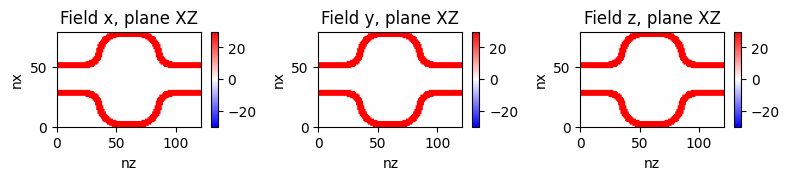

In [11]:
# Built-in method in `Field` class
# to inspect material tensors (ieps, imu, sigma)
# or EM fields E, H, J before simulating

solver.sigma.inspect(plane='XZ', cmap='bwr')

### 🕒 Time-Stepping Routine

Wakis uses the **Leapfrog scheme**, a second-order accurate and explicit time integrator. This method updates the magnetic and electric fields in a staggered fashion:

$$
\begin{align}
\mathbf{h}^{n+1} &= \mathbf{h}^n - \Delta t \, \widetilde{\mathbf{D}}_s \, \mathbf{M}_\mu^{-1} \, \mathbf{D}_A^{-1} \, \mathbf{C} \, \mathbf{e}^{n+0.5} \tag{3a} \\[6pt]
\mathbf{e}^{n+1.5} &= \mathbf{e}^{n+0.5} + \Delta t \, \mathbf{D}_s \, \widetilde{\mathbf{M}}_\varepsilon^{-1} \, \widetilde{\mathbf{D}}_A^{-1} \, \widetilde{\mathbf{C}} \, \mathbf{h}^n 
- \widetilde{\mathbf{M}}_\varepsilon^{-1} \, \mathbf{j}_{\text{src}}^n 
- \widetilde{\mathbf{M}}_\varepsilon^{-1} \, \widetilde{\mathbf{M}}_\sigma \, \mathbf{e}^{n+0.5} \tag{3b}
\end{align}
$$

### Running with custom time-loops
We could create a custom loop by adding a source and advancing the fields:

In [12]:
# ------------ Beam source ----------------
# Beam parameters
sigmaz = 10e-2      #[m] -> 2 GHz
q = 1e-9            #[C]
beta = 1.0          # beam beta 
xs = 0.             # x source position [m]
ys = 0.             # y source position [m]

from wakis.sources import Beam
beam = Beam(q=q, 
            sigmaz=sigmaz, 
            beta=beta,
            xsource=xs, 
            ysource=ys)

In [13]:
# Plotting settings
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('name', plt.cm.jet(np.linspace(0.05, 0.9))) # CST's colormap

plotkw2D = {'title':'img/E_Abs_2d', 
            'add_patch':['cavity'], 'patch_alpha':0.9,
            'patch_reverse' : True, 
            'vmin':0, 'vmax':700,
            'interpolation' : 'gaussian',
            'cmap' : cmap,
            'plane': [slice(0, Nx), int(Ny/2), slice(0, Nz)]}

In [14]:
# Custom time-loop
Nt = 1000          
for n in tqdm(range(Nt)):

    beam.update(solver, n*solver.dt)
    solver.one_step()

    if n%20 == 0 and n>600:
       solver.plot2D('E', component='Abs', **plotkw2D, off_screen=True,n=n)
    

solver.save_state(f'state_n{n}.h5')

100%|████████████████████████████| 1000/1000 [00:46<00:00, 21.53it/s]


In [16]:
!convert -delay 10 -loop 0 img/E_Abs_2d*.png CAP_cavity.gif

Once the simulation is finished, plot the result in a 3D plot:
* Interpolating to the STL cavity
* Or simply cutting the simulation domain

In [28]:
solver.grid.grid.cell_data['Ez'] = np.reshape(solver.E[:,:,:,'y'], solver.N) #this is a 1d numpy array of length N=Nx*Ny*Nz
points = solver.grid.grid.cell_data_to_point_data()
pl = pv.Plotter()
pl.add_mesh_clip_plane(points, normal='-y', opacity=1.0,
                     scalars='Ez', cmap='jet', clim=[-700,700], 
                     normal_rotation=False, nan_opacity=1.0)
pl.show()

Widget(value='<iframe src="http://localhost:36909/index.html?ui=P_0x783e54851d50_8&reconnect=auto" class="pyvi…

In [ ]:
if flag_plot_pyvista:
    solver.plot3DonSTL('E', component='Abs', cmap='jet', clim=[0, 1000],
        stl_with_field='cavity', field_opacity=1.0,
        stl_transparent=['letters'], stl_opacity=0.8, stl_colors='white',
        clip_plane=True, clip_normal='-y', clip_origin=[0,0,0],
        off_screen=False, zoom=1.2, n=n, title='img/E_Abs_3d')

In [ ]:
if flag_plot_pyvista:
    cmap = plt.get_cmap('Blues_r', 10)
    solver.plot3D('E', component='Abs', cmap=cmap, clim=[10, 1000],
            add_stl='letters', stl_opacity=1.0, stl_colors='darkgreen',
            clip_interactive=True, clip_normal='-y',
            off_screen=False, zoom=1.0, n=n, title='img/Ez_3d')

We can also inspect the other components of the fields, e.g. the Electric field:

In [ ]:
solver.E.inspect(cmap='bwr', plane='XZ', dpi=200)

Or reset all of them to zero:

In [ ]:
solver.reset_fields()

And then load the saved state:

In [ ]:
solver.load_state(f'state_n{n}.h5')

### Running with a routine e.g. Wakefield solver

We need to setup our WakeSolve class with the desired beam parameters and wakelength.

#### 🔌 Source: Gaussian Beam Current $J_z$

A rigid Gaussian bunch current is modeled as a line distribution:

$$
\mathbf{J}_z(x_{\text{src}}, y_{\text{src}}, \vec{z}) = 
\frac{q \beta c}{\sqrt{2\pi} \sigma_z} \, 
\exp\left( -\frac{(\vec{s} - s_0)^2}{2\sigma_z^2} \right)
$$

with:
- $\vec{s} = \vec{z} - \beta c t$: beam-frame coordinate
- $s_0 = z_{\min} - \beta c t_{\text{inj}}$: center of bunch
- $q$ the charge in $\text{nC}$
- $\sigma_z$ the bunch length in $\text{m}$

This supports both **ultra-relativistic** ($\beta \approx 1$) and **low-beta** scenarios.

In [ ]:
# ------------ Beam source ----------------
# Beam parameters
sigmaz = 10e-2      #[m] -> f_max = beta*c/3sigmaz
q = 1e-9            #[C]
beta = 1.0          # beam beta 
xs = 0.             # x source position [m]
ys = 0.             # y source position [m]
xt = 0.             # x test position [m]
yt = 0.             # y test position [m]
# [DEFAULT] tinj = 8.53*sigmaz/c_light  # injection time offset [s] 

# Simualtion
wakelength = 30.  # [m]
skip_cells = 10   # no. cells
results_folder = f'results_wl{int(wakelength)}/'
wake = WakeSolver(q=q, 
                  sigmaz=sigmaz, 
                  beta=beta,
                  xsource=xs, ysource=ys, 
                  xtest=xt, ytest=yt,
                  skip_cells=skip_cells,           # Skip cells for wake potential integration at the boundary 
                  results_folder=results_folder,   
                  Ez_file=results_folder+'Ez.h5')

In [ ]:
# ----------- Solver & Simulation ----------
# boundary conditions``
bc_low=['pec', 'pec', 'pec']
bc_high=['pec', 'pec', 'pec']

solver = SolverFIT3D(grid, wake,
                     bc_low=bc_low, bc_high=bc_high, 
                     bg='pec',      # backgorund material
                     use_stl=True,  # enable/disable geometry
                     use_mpi=False, # activate MPI
                     use_gpu=True, # activate GPU
                     )

In [ ]:
# Some built-in plotting kwargs:
plotkw2D = {'title':'img/E_z', 
            'add_patch':['cavity'], 'patch_alpha':0.9,
            'patch_reverse' : True, 
            'vmin':0, 'vmax':700,
            'interpolation' : 'gaussian',
            'cmap' : 'jet',
            'plane': [slice(0, Nx), int(Ny/2), slice(0, Nz)]}

In [ ]:
# Wakefield Solver run
solver.wakesolve(wakelength=wakelength, 
                 plot=False, # turn False for speedup
                 plot_every=30, plot_until=3000, **plotkw2D
                 )

### 📈 Wake Potential and Impedance from 3D electromganetic simulations

Once the 3D E;ectromagnetic is done, Wakis will compute the wake potential and the impedance from the simulated fields:



* It will take care of saving the fields for the wake potential and impedance calculations:
  
The **wake potential**, expressed in $\text{V/pC}$, is calculated by integrating the electric and magnetic fields seen by a test particle as it follows behind the source:

$$
W(s) = \frac{1}{q_s} \int_{-\infty}^{\infty} \left[ E_z(z, t) + \beta c \, \vec{e}_z \times \vec{B}(z, t) \right]_{t = (s + z)/c} \, dz
$$

For ultra-relativistic beams, the transverse component vanishes, and the expression simplifies to:

$$
W_\parallel(s) = \frac{1}{q_s} \int_{-\infty}^{\infty} E_z(z, t = (s + z)/c) \, dz
$$

The **transverse wake potential** is recovered via the **Panofsky-Wenzel theorem**:

$$
W_{\perp,\alpha}(s) = \frac{\partial}{\partial \alpha} \int_{-\infty}^{s} W_\parallel(s') \, ds', \quad \alpha = x, y
$$

Wakis implements this gradient using second-order finite differences.

#### From Wake to Impedance

Given the bunch profile $\lambda(s)$ and the wake potential $W(s)$, the beam coupling impedance is computed in Fourier space ia a deconvolution:

- **Longitudinal impedance** in $\Omega$:

$$
Z_\parallel(\omega) = \beta c \cdot \frac{\mathcal{F}[W_\parallel(s)]}{\mathcal{F}[\lambda(s)]}
$$

- **Transverse impedance** in $\Omega/m$:

$$
Z_\perp(\omega) = -i \beta c \cdot \frac{\mathcal{F}[W_\perp(s)]}{\mathcal{F}[\lambda(s)]}
$$

where $\mathcal{F}$ denotes the Fourier transform. Wakis uses `numpy.fft` and zero-padding for smooth frequency analysis.

In [ ]:
# Plot longitudinal wake potential and impedance
fig1, ax = plt.subplots(1,2, figsize=[12,4], dpi=150)
ax[0].plot(wake.s*1e2, wake.WP, c='tab:red', lw=1.5, label='Wakis')
ax[0].set_xlabel('s [cm]')
ax[0].set_ylabel('Longitudinal wake potential [V/pC]', color='tab:red')
ax[0].legend()
ax[0].set_xlim(xmax=wakelength*1e2)

ax[1].plot(wake.f*1e-9, np.abs(wake.Z), c='tab:blue', alpha=0.8, lw=2, label='Abs')
ax[1].plot(wake.f*1e-9, np.real(wake.Z), ls='--', c='tab:blue', lw=1.5, label='Real')
ax[1].plot(wake.f*1e-9, np.imag(wake.Z), ls=':', c='tab:blue', lw=1.5, label='Imag')
ax[1].set_xlabel('f [GHz]')
ax[1].set_ylabel('Longitudinal impedance [Abs][$\Omega$]', color='tab:blue')
ax[1].legend()

fig1.tight_layout()
fig1.savefig(results_folder+'longitudinal.png')
#plt.show()

In [ ]:
# Plot transverse x wake potential and impedance
fig2, ax = plt.subplots(1,2, figsize=[12,4], dpi=150)
ax[0].plot(wake.s*1e2, wake.WPx, c='tab:orange', lw=1.5, label='Wakis')
ax[0].set_xlabel('s [cm]')
ax[0].set_ylabel('Transverse wake potential X [V/pC]', color='tab:orange')
ax[0].legend()
ax[0].set_xlim(xmax=wakelength*1e2)

ax[1].plot(wake.f*1e-9, np.abs(wake.Zx), c='tab:green', lw=2, label='Abs')
ax[1].plot(wake.f*1e-9, np.real(wake.Zx), c='tab:green', ls='--', lw=1.5, label='Real')
ax[1].plot(wake.f*1e-9, np.imag(wake.Zx), c='tab:green', ls=':', lw=1.5, label='Imag')
ax[1].set_xlabel('f [GHz]')
ax[1].set_ylabel('Transverse impedance X [Abs][$\Omega$]', color='tab:green')
ax[1].legend()

fig2.tight_layout()
fig2.savefig(results_folder+'001_transverse_x.png')
#plt.show()

In [ ]:
# Plot transverse y wake potential and impedance
fig3, ax = plt.subplots(1,2, figsize=[12,4], dpi=150)
ax[0].plot(wake.s*1e2, wake.WPy, c='tab:brown', lw=1.5, label='Wakis')
ax[0].set_xlabel('s [cm]')
ax[0].set_ylabel('Transverse wake potential Y [V/pC]', color='tab:brown')
ax[0].legend()
ax[0].set_xlim(xmax=wakelength*1e2)

ax[1].plot(wake.f*1e-9, np.abs(wake.Zy), c='tab:pink', lw=2, label='Abs')
ax[1].plot(wake.f*1e-9, np.real(wake.Zy), c='tab:pink', ls='--', lw=1.5, label='Real')
ax[1].plot(wake.f*1e-9, np.imag(wake.Zy), c='tab:pink', ls=':', lw=1.5, label='Imag')
ax[1].set_xlabel('f [GHz]')
ax[1].set_ylabel('Transverse impedance Y [Abs][$\Omega$]', color='tab:pink')
ax[1].legend()

fig3.tight_layout()
fig3.savefig(results_folder+'transverse_y.png')
#plt.show()

Or plot the field at the last timestep at different transverse positions:

In [ ]:
# %matplotlib ipympl
# Plot Electric field component in 2D using imshow
solver.plot1D(field='E', component='z', 
              line='z', pos=[0.1, 0.2, 0.35, 0.5, 0.6], 
              xscale='linear', yscale='linear',
              off_screen=False, title=results_folder+'Ez1d')

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('name', plt.cm.jet(np.linspace(0.1, 0.9))) # CST's colormap

# Plot Electric field component in 2D using imshow
solver.plot2D(field='E', component='z', 
              plane='ZX', pos=0.5, 
              cmap=cmap, vmin=-100, vmax=100., interpolation='hanning',
              add_patch='cavity', patch_reverse=True, patch_alpha=0.8, 
              off_screen=False)